<a href="https://colab.research.google.com/github/Nevermetyou65/GANs-Exercises/blob/main/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1 
img_shape = (img_rows, img_cols, channels)
z_dim = 100
num_classes = 10

In [ ]:
def build_generator(z_dim):
    model = Sequential()
    model.add(layers.Dense(units=256*7*7, input_shape=(z_dim,)))
    model.add(layers.Reshape((7,7,256)))

    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(layers.Activation('tanh'))

    return model

def build_cgan_generator(z_dim):

    # functional API
    z = Input(shape=(z_dim,))
    label = Input(shape=(1,), dtype='int32')

    # make dense vector of label
    label_embedding = layers.Embedding(num_classes, z_dim, input_length=1)(label)
    label_embedding = layers.Flatten()(label_embedding)

    # ตรงนี้คือเอา label dense vector มาคูณกับ sample from latent space z
    joined_representation = layers.Multiply()([z, label_embedding])

    generator = build_generator(z_dim)
    conditioned_img = generator(joined_representation)

    return Model(inputs=[z, label], outputs=conditioned_img)

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()
    model.add(layers.Conv2D(
        64, kernel_size=3, strides=2,
        input_shape=(img_shape[0], img_shape[1], img_shape[2]+1)))
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=1, activation='sigmoid'))

    return model

def build_cgan_discriminator(img_shape):

    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape(img_shape)(label_embedding)

    # ซ้อนภาพ กับ matrix ของ label
    concatenated = layers.Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(img_shape)
    classification = discriminator(concatenated)

    return Model(inputs=[img, label], outputs=classification)

In [ ]:
def build_cgan(generator, discriminator):
    
    # ใช้ train generator อย่างเดียว
    # สังเกตจาก discriminator รับแค่ fake image จาก generator
    z = Input(shape=(z_dim,))
    label = Input(shape=(1,))

    # ใส่ label เดียวกันเข้าไปใน generator และ discriminator
    img = generator([z, label]) # conditioned images
    classification = discriminator([img, label])
    
    # model ใหญ่
    model = Model(inputs=[z, label], outputs=classification)

    return model

In [ ]:
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_cgan_generator(z_dim)
discriminator.trainable = False
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):

    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = (X_train / 127.5) - 1.
    X_train = np.expand_dims(X_train, axis=-1)

    # target data
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # 1a
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx] # (x, y) -> real images + labels

        # 1c
        z = np.random.normal(0, 1, size=(batch_size, z_dim)) # (z, y) -> sample from latent spaces + labels
        gen_imgs = generator.predict([z, labels]) # conditioned fake images

        # 1b, 1d
        D_loss_real = discriminator.train_on_batch([imgs, labels], real)
        D_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)
        # --------------------------------------------------------------------

        z = np.random.normal(0, 1, (batch_size, z_dim))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        G_loss = cgan.train_on_batch([z, labels], real)
        # --------------------------------------------------------------------

        if (iteration+1) % sample_interval == 0:
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(iteration+1, D_loss[0],
                                                                 100 * D_loss[1], G_loss))
            losses.append((D_loss[0], G_loss))
            accuracies.append(100 * D_loss[1])
            sample_images()

In [ ]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = generator.predict([z, labels])

    gen_imgs = 0.5*gen_imgs + 0.5 # rescale to [0, 1]
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns,
                            figsize=(10, 4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit : %d" %labels[cnt])
            cnt += 1

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.067983, acc.: 96.88%] [G loss: 3.746143]
2000 [D loss: 0.001749, acc.: 100.00%] [G loss: 0.579478]
3000 [D loss: 0.001782, acc.: 100.00%] [G loss: 7.716042]
4000 [D loss: 0.011657, acc.: 100.00%] [G loss: 3.762454]
5000 [D loss: 0.001059, acc.: 100.00%] [G loss: 11.891224]
6000 [D loss: 0.006395, acc.: 100.00%] [G loss: 6.898366]
7000 [D loss: 0.087889, acc.: 95.31%] [G loss: 6.813072]
8000 [D loss: 0.277078, acc.: 89.06%] [G loss: 4.332890]
9000 [D loss: 0.344919, acc.: 82.81%] [G loss: 3.557774]
10000 [D loss: 0.232410, acc.: 89.06%] [G loss: 2.916469]
11000 [D loss: 0.222139, acc.: 92.19%] [G loss: 3.161709]
12000 [D loss: 0.367665, acc.: 85.94%] [G loss: 2.751627]


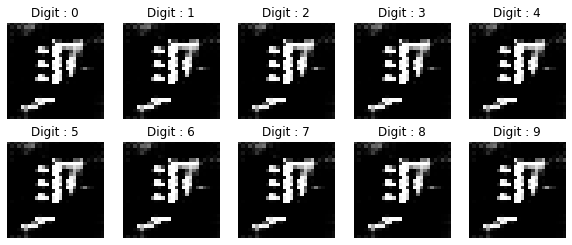

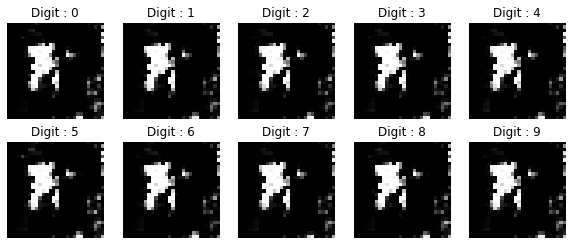

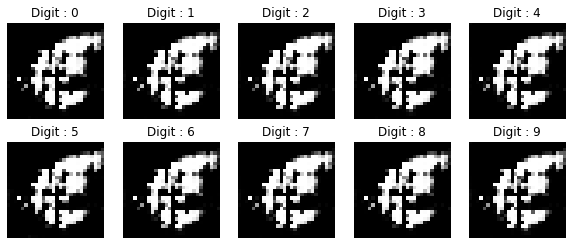

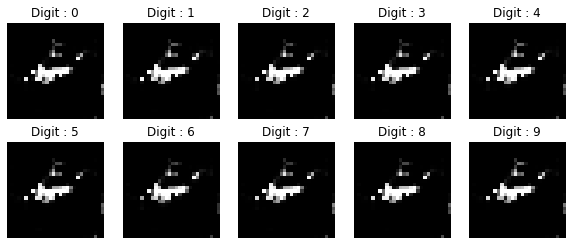

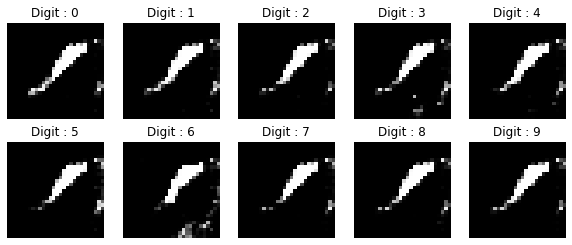

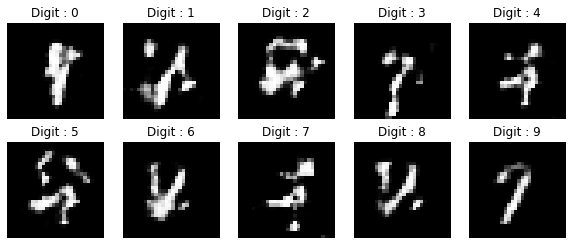

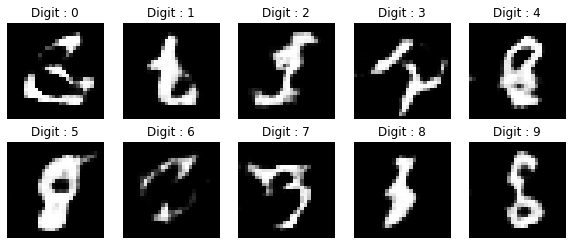

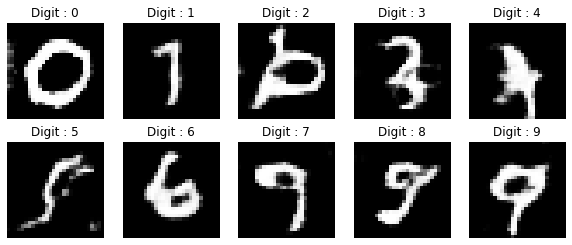

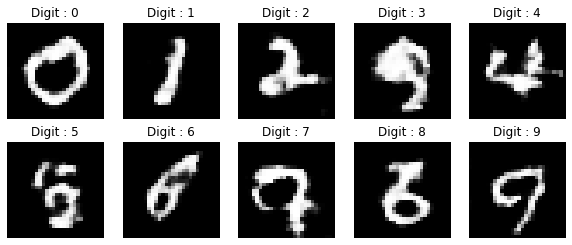

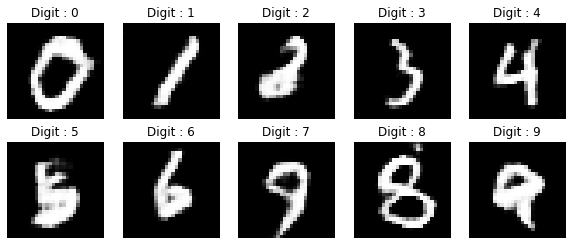

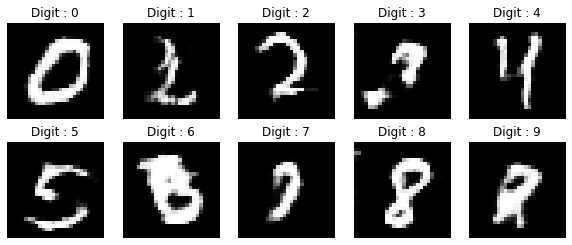

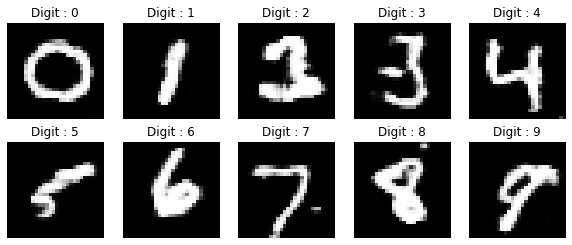

In [ ]:
iterations = 12000
batch_size = 32
sample_interval = 1000

train(iterations, batch_size, sample_interval)

shape: (50, 1)


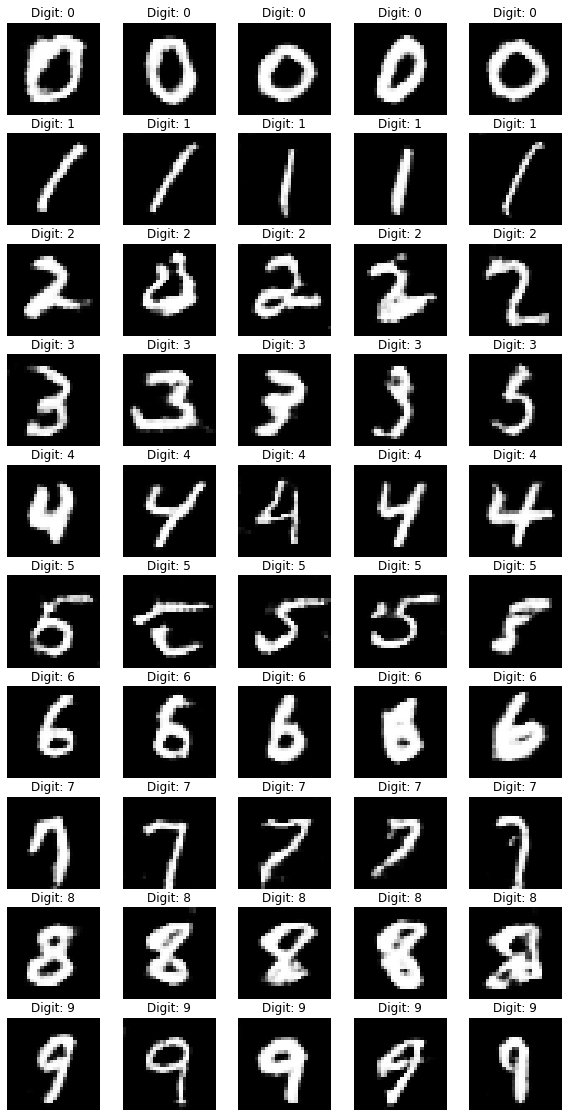

In [ ]:
rows = 10
columns = 5
z = np.random.normal(0, 1, size=(rows*columns, z_dim))
random_labels = np.array([[i for j in range(5)] for i in range(10)]).flatten().reshape((-1, 1))
print('shape:', random_labels.shape)
# print(random_labels[::2, :])

gen_imgs = generator.predict([z, random_labels])
gen_imgs = 0.5*gen_imgs + 0.5
fig, axs = plt.subplots(rows,
                        columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(rows):
    for j in range(columns):
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % random_labels[cnt])
        cnt += 1

(1, 1)
(1, 28, 28, 1)


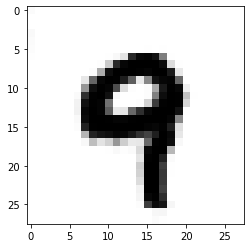

In [ ]:
labels = np.array(9, dtype='int32').reshape((-1, 1))
print(labels.shape)
z = np.random.normal(0, 1, size=(1, z_dim))
test_gen_imgs = generator([z, labels])
test_gen_imgs = 0.5*test_gen_imgs + 0.5
print(test_gen_imgs.shape)
plt.imshow(test_gen_imgs[0, :, :, 0], cmap='binary')
plt.show()